In [1]:
import numpy as np
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import matrix_product, matrix_transpose, rotation_matrix
import pickle 
import scipy.interpolate as scint
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import gala.coordinates as gc

In [2]:
class ArbitraryPoleFrame(coord.BaseCoordinateFrame):
    
    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'phi1'),
            coord.RepresentationMapping('lat', 'phi2'),
            coord.RepresentationMapping('distance', 'distance')],
        coord.SphericalCosLatDifferential:[
            coord.RepresentationMapping('d_lon_coslat', 'pm_phi1_cosphi2'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')],
        coord.SphericalDifferential: [
            coord.RepresentationMapping('d_lon', 'pm_phi1'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')]
    }
    
    pole = coord.CoordinateAttribute(frame=coord.ICRS)    
    roll = coord.QuantityAttribute(default=0*u.degree)

In [3]:
@frame_transform_graph.transform(coord.DynamicMatrixTransform, coord.ICRS, ArbitraryPoleFrame)
def icrs_to_arbpole(icrs_coord, arbpole_frame):
    
    roll = arbpole_frame.roll
    pole = arbpole_frame.pole
    
    # Align z(new) with direction to M31
    mat1 = rotation_matrix(-pole.dec, 'y')
    mat2 = rotation_matrix(pole.ra, 'z')
    mat3 = rotation_matrix(roll, 'z')
    mat4 = rotation_matrix(90*u.degree, 'y')
    R = matrix_product(mat4, mat1, mat2, mat3)
    
    return R

@frame_transform_graph.transform(coord.DynamicMatrixTransform, ArbitraryPoleFrame, coord.ICRS)
def arbpole_to_icrs(arbpole_coord, icrs_frame):
    return matrix_transpose(icrs_to_arbpole(None, arbpole_coord))

def solar_reflex_pm(ra, dec, d, lsr=None):
    if lsr is None: 
        lsr = np.array([-11.1, 12.1, 7.25])*u.km/u.s

    #transform from ra, dec, distance to x, y, z in galactic coordinates
    equa = coord.ICRS(ra=ra, dec=dec, distance=d)
    gal = equa.transform_to(coord.Galactocentric)
    xyz = np.array([gal.x - 8.0*u.kpc, gal.y, gal.z]).T
    #xyz_sun = np.array([8.0, 0.0, 0.0], np.newaxis)

    #put in line of sight from sun rather than center of galaxy 
    los = xyz# - xyz_sun
    los *= 1./np.linalg.norm(los)
    print los, los.shape
    #l component is cross product of LOS with z hat 
    zhat  = np.array([0., 0., 1.])*u.kpc
    lnorm = np.cross(los, zhat)
    lnorm *= 1./np.linalg.norm(lnorm)

    #b component is cross product of l component with LOS 
    bnorm = np.cross(lnorm, los)
    bnorm *= 1./np.linalg.norm(bnorm)

    #solar motion
    uvw_localstuff = np.array([0.0, 235.0, 0.0])*u.km/u.s
    uvw_sun = uvw_localstuff + lsr
    uvw_relativeToSun = -1.*uvw_sun

    #radial velocity of the sun: solar motion projected onto line of sight
    vr_sun = np.dot(uvw_relativeToSun, los.T)

    #l velocity of sun: solar motion projected onto normalized l vector 
    pml_sun = np.dot(uvw_relativeToSun, lnorm.T)/d

    #b velocity of sun: solar motion prjected onto normalized b vector 
    pmb_sun = np.dot(uvw_relativeToSun, bnorm.T)/d

    return (pml_sun*u.rad).to(u.mas/u.yr), (pmb_sun*u.rad).to(u.mas/u.yr)


In [4]:
with open('gaiasdssHaloNew_30b.pkl') as f:
    data = pickle.load(f)

In [8]:
xkey = 's_ra1'
ykey = 's_dec1'
pmxkey = 'pmra_new'
pmykey = 'pmdec_new' 
lsr = [11.1, 12.1, 7.25]*u.km/u.s
galactic_v = [0.0, 220., 0.0]*u.km/u.s
v_sun = coord.CartesianDifferential(lsr + galactic_v)

In [65]:
g_r = (data['psfmag_g'] - data['extinction_g']) - (data['psfmag_r'] - data['extinction_r'])
rmag = data['psfmag_r'] - data['extinction_r']
colorCut = (g_r > 0.15) & (g_r < 0.41) 
magCut = (rmag > 18.1)  & (rmag < 19.85) 
#0.15 < g − r < 0.41 and 18.1 < r < 19.85

In [151]:
observed = coord.ICRS(ra=data[xkey]*u.deg, dec=data[ykey]*u.deg, 
                      pm_ra_cosdec=data[pmxkey]*u.mas/u.yr, pm_dec=data[pmykey]*u.mas/u.yr, 
                      distance=8.*u.kpc)
observed = observed.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
new_gal_observed = coord.Galactic(rep)

In [41]:
#define coordinate system for data
#sky = coord.ICRS(ra=data[xkey]*u.deg, dec=data[ykey]*u.deg, pm_ra_cosdec=data[pmxkey]*u.mas/u.yr, pm_dec=data[pmykey]*u.mas/u.yr)


In [152]:
#define ra, dec of great circle pole
rapole  = 34.5987*u.deg
decpole = 29.7331*u.deg

pole = coord.ICRS(ra=rapole, 
                  dec=decpole)
frame = ArbitraryPoleFrame(pole=pole)

#align frame with pole 
newframe = new_gal_observed.transform_to(gc.GD1) #frame)#sky.transform_to(frame) #frame
#newframe2 = sky.transform_to(gc.GD1)
#newframeSun = sun.transform_to(frame)
pmphi1 = newframe.pm_phi1_cosphi2 # - newframeSun.pm_phi1_cosphi2
pmphi2 = newframe.pm_phi2 # - newframeSun.pm_phi2
phi1 = newframe.phi1.wrap_at(180*u.deg)
phi2 = newframe.phi2


In [149]:
ind = 0
ra           = data[xkey]  [ind]*u.deg
dec          = data[ykey]  [ind]*u.deg
pm_ra_cosdec = data[pmxkey][ind]*u.mas/u.yr
pm_dec       = data[pmykey][ind]*u.mas/u.yr
obj1 = coord.ICRS(ra=ra, dec=dec, pm_ra_cosdec=pm_ra_cosdec, pm_dec=pm_dec, distance=8.*u.kpc)

T = 100 * u.yr
ra2 = ra + pm_ra_cosdec * T / np.cos(dec)
dec2 = dec + pm_dec * T
obj2 = coord.ICRS(ra=ra2, dec=dec2, pm_ra_cosdec=pm_ra_cosdec, pm_dec=pm_dec, distance=8.*u.kpc)

obj3 = obj1.transform_to(gc.GD1)

phi1 = obj3.phi1 + obj3.pm_phi1_cosphi2 * T / np.cos(obj3.phi2)
phi2 = obj3.phi2 + obj3.pm_phi2 * T
obj4 = obj2.transform_to(gc.GD1)

print obj4
print phi1.value, phi2.value

<GD1 Coordinate: (phi1, phi2, distance) in (deg, deg, kpc)
    ( 288.66291184, -17.74070639,  8.)
 (pm_phi1_cosphi2, pm_phi2) in mas / yr
    (-15.3677017,  34.9741491)>
288.662911589 -17.7407064426


In [146]:
newl = obj1.l + obj1.pm_l_cosb * dt / np.cos(obj1.b)
newb = obj1.b + obj1.pm_b * dt
newra = 

print obj1.l
print newl
print obj1.b
print newb

235d05m16.0769s
235d05m12.8329s
37d27m47.9159s
37d27m45.0939s


In [130]:
np.allclose(((data[pmxkey])**2. + (data[pmykey])**2.), (pmphi1.value**2. + pmphi2.value**2.))

True

In [88]:
from scipy.ndimage import gaussian_filter

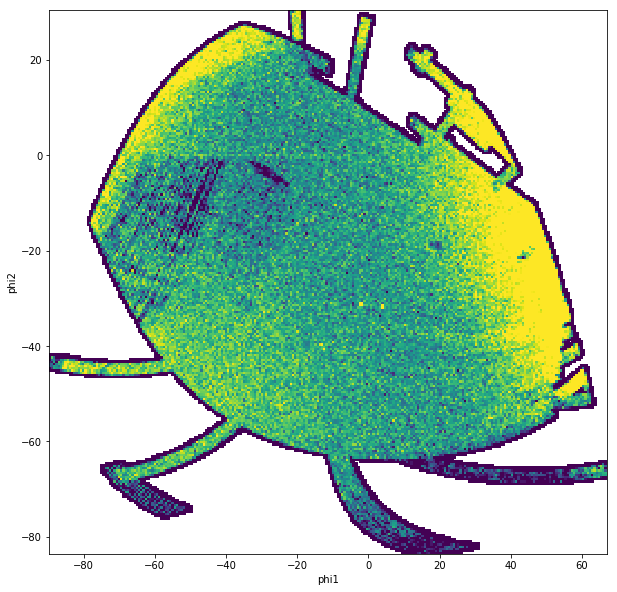

In [121]:
extent_along_stream = 15*u.mas/u.yr
width_of_stream = 5*u.mas/u.yr
indices = (np.abs(pmphi1) < extent_along_stream) & (np.abs(pmphi2) < width_of_stream) &colorCut & magCut

x = phi1[indices].value
y = phi2[indices].value

#x[x > 180.] = x[x > 180.] - 360.
# plt.hist2d(x, y, bins=[250,250], norm=mpl.colors.LogNorm(vmin=10, vmax=100)) #, range= [[-80, 210],[-10, 10]] )

H, xedges, yedges = np.histogram2d(x, y, bins=(250, 250))
H = gaussian_filter(H, sigma=0.2).T
plt.pcolormesh(xedges, yedges, H, norm=mpl.colors.LogNorm(vmin=10, vmax=50))

plt.xlabel('phi1')
plt.ylabel('phi2')
fig = mpl.pyplot.gcf()
fig.set_size_inches(10,10)
#plt.savefig('gd1rot.pdf', rasterized=True)

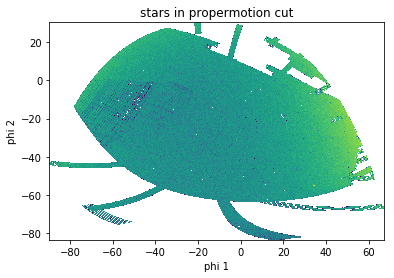

In [60]:
plt.hist2d(phi1[data['psfmag_r'] < 20], phi2[data['psfmag_r'] < 20], bins=1000, norm=mpl.colors.LogNorm())
#plt.ylim(-10, 10)
plt.xlabel('phi 1')
plt.ylabel('phi 2')
plt.title('stars in propermotion cut')
plt.savefig('rotatedFrame.pdf', rasterized=True)

In [22]:
#set up search parameters
#propermotion not perpendicular to the great circle (pmphi2 ~ 0)
#propermotion along great circle < 20 mas/yr
pmphi1_center = 0.*u.mas/u.yr
pmphi2_center = 0.*u.mas/u.yr
pmphi1_width = 15.*u.mas/u.yr
pmphi2_width = 5.*u.mas/u.yr

pmphi1_edges = np.arange(-16, 16.001, 4)*u.mas/u.yr
pmphi2_edges = pmphi1_edges

#search various segmets of phi1
#constrain phi2 to be < 0.25 degrees from great circle
deltaphi1_search = 5.*u.deg #shift of phi1 when searching 
deltaphi2_bin = 0.1*u.deg        #width of bins when fitting for signal and background

phi1_width = deltaphi1_search*2. #width of phi1 for search
phi2_width = 0.25*u.deg          #width of phi2, close to equator
phi1_left_edges = np.arange(0., 360., deltaphi1_search.value)*u.deg
phi1_right_edges = phi1_left_edges + phi1_width
phi1_centers = (phi1_right_edges + phi1_left_edges)/2.
for x in [phi1_centers, phi1_right_edges]:
    x[x > 360.*u.deg] =  x[x > 360.*u.deg] - 360.*u.deg
phi2_center = 0.*u.deg           #equator

background_center = 0.*u.deg     #center of background filter
background_widthmax = 2.*u.deg   #maximum extent to calculate background
background_widthmin = phi2_width #minimum extent for background, exclude signal 

signalbins = np.arange(-phi2_width.value, phi2_width.value+0.0001, deltaphi2_bin.value)*u.deg
signalcenters = (signalbins[1:]+signalbins[:-1])/2.

backgroundbins_low  = np.arange(-background_widthmax.value, -background_widthmin.value+0.0001, deltaphi2_bin.value)*u.deg 
backgroundbins_high = np.arange(background_widthmin.value,   background_widthmax.value+0.0001, deltaphi2_bin.value)*u.deg
backgroundcenters_low = (backgroundbins_low[1:]+backgroundbins_low[:-1])/2.
backgroundcenters_high = (backgroundbins_high[1:]+backgroundbins_high[:-1])/2.

allbins = np.arange(-background_widthmax.value, background_widthmax.value+0.0001, deltaphi2_bin.value)*u.deg
allcenters = (allbins[1:] + allbins[:-1])/2.

-52.8798137717 37.311932406 (22, 22)
[-11.5] [-10.] [-13.]
[-7.] [-5.5] [-8.5]


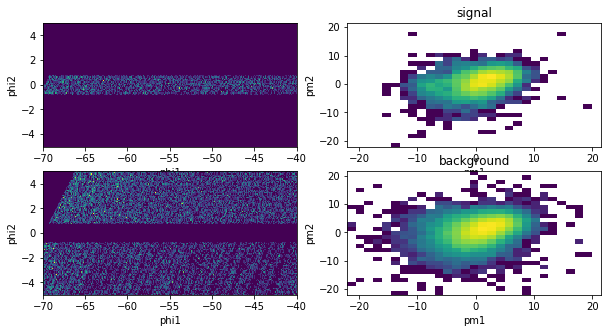

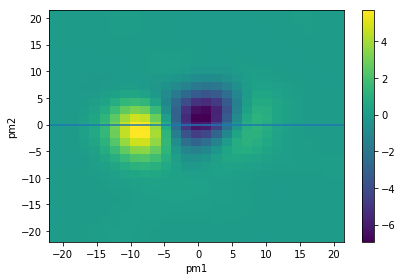

In [179]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
phi1min = -70.*u.deg #105*u.deg
phi1max = -40.*u.deg #115*u.deg
phi2min = -0.75*u.deg
phi2max = 0.75*u.deg

phi2max_b = 5.0*u.deg
phi2min_b = 0.75*u.deg

dphi1 = phi1max - phi1min
dphi2 = phi2max - phi2min
dphi2_b = phi2max_b - phi2min_b

areaSignal = dphi1*dphi2
areaBackground = (dphi1*dphi2_b)*2.

dpm1 = 22.#*u.mas/u.yr
dpm2 = 22.#*u.mas/u.yr
deltapm = 1.5#*u.mas/u.yr

deltaphi = 0.1

signal_edges_pm1 = [-dphi1/2., dphi1/2.]
signal_edges_pm2 = [-dphi2/2., dphi2/2.]
background_edges_pm1 = [-dphi1/2., dphi1/2.]
background_edges_pm2 = [-(dphi2_b + dphi2)/2., -dphi2/2.]
backgtound_edges_pm2 = [dphi2/2., (dphi2_b+dphi2)/2.]

signal_indices = (phi1 >= phi1min) & (phi1 <= phi1max) & \
                 (phi2 >= phi2min) & (phi2 <= phi2max) & colorCut & magCut
background_indices = (phi1 >= phi1min) & (phi1 <= phi1max) & \
                     np.logical_or((phi2 > phi2min_b) & (phi2 <= phi2max_b),
                                   (phi2 >= -phi2max_b) & (phi2 <= -phi2min_b)) & colorCut & magCut
                     
pm1_edges = np.arange(-dpm1, dpm1+0.001, deltapm) 
pm2_edges = np.arange(-dpm2, dpm2+0.001, deltapm)

phi1_edges = np.arange(phi1min.value, phi1max.value+000.1, deltaphi)
phi2_edges = np.arange(-phi2max_b.value, phi2max_b.value+000.1, deltaphi)


H, xedges, yedges = np.histogram2d(pmphi1[signal_indices].value,     
                                   pmphi2[signal_indices].value, 
                                   bins=[pm1_edges, pm2_edges])
Hback, xe, ye     = np.histogram2d(pmphi1[background_indices].value, 
                                   pmphi2[background_indices].value, 
                                   bins=[pm1_edges, pm2_edges])

histSig_pos, xe, ye  = np.histogram2d(phi1[signal_indices].value, 
                                              phi2[signal_indices].value, 
                                              bins=[phi1_edges, phi2_edges])
histBack_pos, xe, ye = np.histogram2d(phi1[background_indices].value, 
                                              phi2[background_indices].value, 
                                              bins=[phi1_edges, phi2_edges])

areaNorm = np.sum(histSig_pos > 0)/np.float(np.sum(histBack_pos > 0))
finalhist = gaussian_filter(H - Hback*areaNorm, sigma=2.0)
#finalhist = H - Hback*areaNorm 

print np.min(finalHist), np.max(finalHist), np.shape(finalHist)
fig2, ax2 = plt.subplots()


blah = ax2.pcolormesh(xedges, yedges, finalhist.T) #, norm=mpl.colors.LogNorm(vmin=1, vmax=10))


#blah = ax2.imshow(finalHist.T, extent=[-21, 21, -21, 21], origin='lower', vmin=-5)#, norm=mpl.colors.LogNorm())
ax2.set_xlabel('pm1')
ax2.set_ylabel('pm2')
ax2.axhline(0.0)
plt.colorbar(blah)
ax[0, 0].hist2d(phi1[signal_indices], phi2[signal_indices], bins=[phi1_edges, phi2_edges])
for axis in [ax[0, 0], ax[1, 0]]:
    axis.set_xlabel('phi1')
    axis.set_ylabel('phi2')
for axis in [ax[0, 1], ax[1, 1]]:
    axis.set_xlabel('pm1')
    axis.set_ylabel('pm2')
(counts, xedges, yedges, ax1) = ax[0, 1].hist2d(pmphi1[signal_indices], pmphi2[signal_indices], bins=[pm1_edges, pm2_edges], norm=mpl.colors.LogNorm())
ax[0, 1].set_title('signal')
ax[1, 0].hist2d(phi1[background_indices], phi2[background_indices], bins=[phi1_edges, phi2_edges])
(counts, xedges, yedges, ax2) = ax[1, 1].hist2d(pmphi1[background_indices], pmphi2[background_indices], bins=[pm1_edges, pm2_edges], norm=mpl.colors.LogNorm())
ax[1, 1].set_title('background')
#fig.colorbar(ax1, ax=ax[0, 1])
#fig.colorbar(ax2, ax=ax[1, 1])
plt.tight_layout()
fig.savefig('gd1Distributions.png')
fig2.savefig('gd1_pm.png')

xind = np.where(finalHist == np.max(finalHist))[0]
yind = np.where(finalHist == np.max(finalHist))[1]
print xedges[xind], xedges[xind+1], xedges[xind-1]
print yedges[yind], yedges[yind+1], yedges[yind-1]

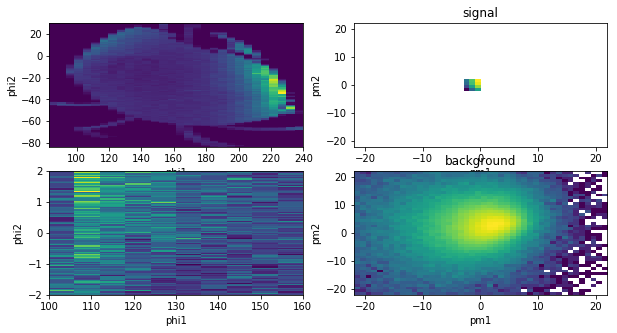

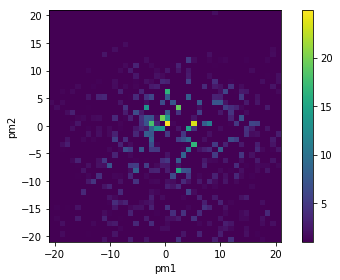

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
pmphi1min = -3*u.mas/u.yr
pmphi1max = 0*u.mas/u.yr
pmphi2min = -2.0*u.mas/u.yr
pmphi2max = 2.0*u.mas/u.yr


phi2max_b = 5.0*u.deg
phi2min_b = 0.5*u.deg

signal_indices = (pmphi1 >= pmphi1min) & (pmphi1 <= pmphi1max) & \
                 (pmphi2 >= pmphi2min) & (pmphi2 <= pmphi2max)

background_indices 
#background_indices = (pmphi1 >= pmphi1min) & (pmphi1 <= pmphi1max) & \
#                     np.logical_or((pmphi2 >= pmphi2min_b) & (pmphi2 <= pmphi2max_b),
#                                   (pmphi2 >= -pmphi2max_b) & (pmphi2 <= -pmphi2min_b))
  
fig2, ax2 = plt.subplots()
blah = ax2.imshow(finalHist, extent=[-21, 21, -21, 21], origin='lower', vmin=1.)#, norm=mpl.colors.LogNorm())
ax2.set_xlabel('pm1')
ax2.set_ylabel('pm2')
plt.colorbar(blah)
ax[0, 0].hist2d(phi1[signal_indices], phi2[signal_indices], bins=[30,100])
for axis in [ax[0, 0], ax[1, 0]]:
    axis.set_xlabel('phi1')
    axis.set_ylabel('phi2')
for axis in [ax[0, 1], ax[1, 1]]:
    axis.set_xlabel('pm1')
    axis.set_ylabel('pm2')
ax[0, 1].hist2d(pmphi1[signal_indices], pmphi2[signal_indices], bins=[pm1_edges, pm2_edges], norm=mpl.colors.LogNorm())
ax[0, 1].set_title('signal')
ax[1, 0].hist2d(phi1[signal_indices], phi2[signal_indices], bins=[10,100], range=[[100, 160], [-2, 2]])
ax[1, 1].hist2d(pmphi1[background_indices], pmphi2[background_indices], bins=[pm1_edges, pm2_edges], norm=mpl.colors.LogNorm())
ax[1, 1].set_title('background')
plt.tight_layout()
fig.savefig('gd1Distributions.png')
fig2.savefig('gd1_pm.png')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
4.21201239966
24
6.08174260189
25
5.00384294415
26
4.72843016704
27
4.25170082864
28
4.19437272558
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


KeyboardInterrupt: 

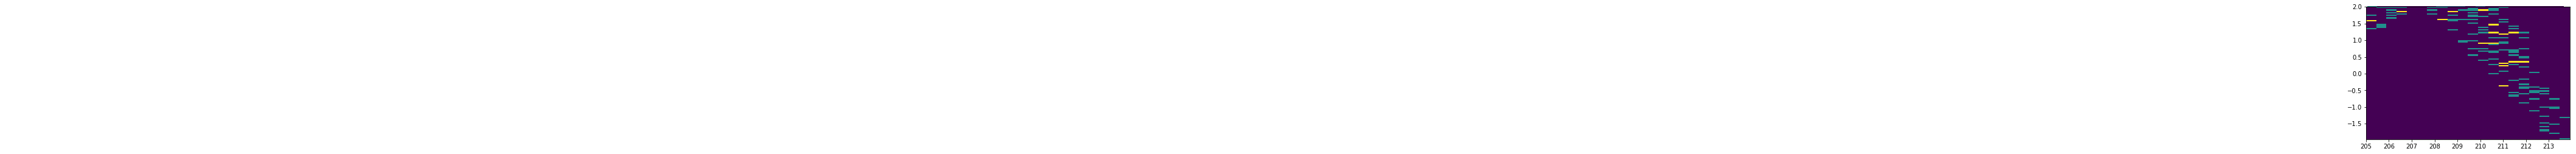

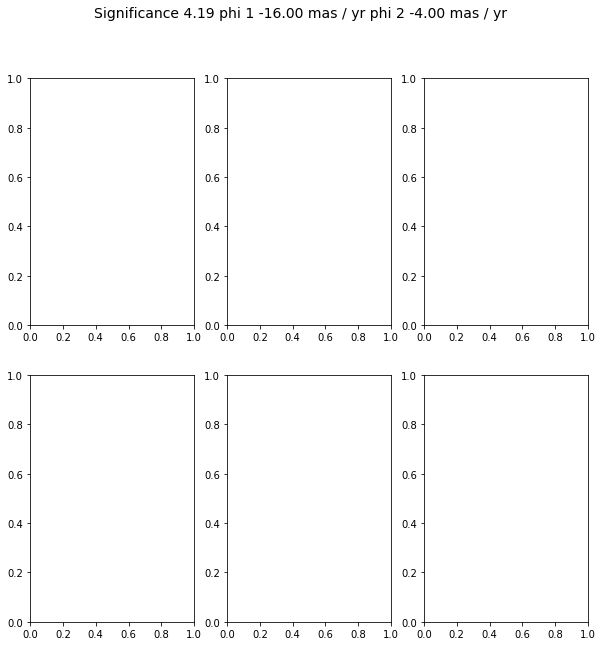

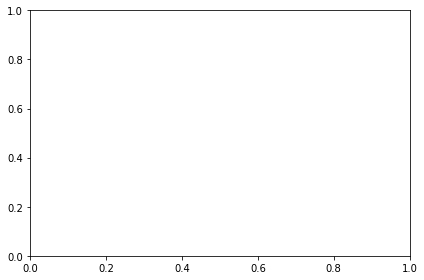

In [70]:

figAll, axesAll = plt.subplots()
fig, axes = plt.subplots(2, 3, figsize=(10,10))
fig2, axes2 = plt.subplots()
axes = axes.flatten()
excessCurrent = np.zeros(len(phi1_right_edges))
excess = np.zeros((len(pmphi1_edges)-1, len(pmphi2_edges)-1))
for j, (pm1_l, pm1_r) in enumerate(zip(pmphi1_edges[:-1], pmphi1_edges[1:])):
    for k, (pm2_l, pm2_r) in enumerate(zip(pmphi2_edges[:-1], pmphi2_edges[1:])):
        pmindices = (pmphi1 > pm1_l) & (pmphi1 <= pm1_r) &\
                    (pmphi2 > pm2_l) & (pmphi2 <= pm2_r)
        axes2.cla()
        for i, (l, r) in enumerate(zip(phi1_left_edges, phi1_right_edges)): #np.unique(phi1bins):
            print i
            #for i, l, r in zip([24], [phi1_left_edges[24]], [phi1_right_edges[24]]):
            for a in axes: a.cla()
            #search for over densities of stars along equator in Phi1 delta degree increments
            #stream is Phi2 = +-0.25 degrees from equator
            #background is Phi2 = +-2 degrees excluding stream 
            deltaPhi2 = phi2 - phi2_center

            posindices  = (phi1 >= l) & \
                          (phi1 <  r) & \
                          (np.abs(deltaPhi2) <= phi2_width) & pmindices
            if np.sum(posindices):
                notindices = (phi1 >= l) & \
                              (phi1 <  r) & \
                              (np.abs(deltaPhi2) <= background_widthmax) & ~pmindices

                backindices_low = (phi1 >= l) & \
                              (phi1 <  r) & \
                              (deltaPhi2 > -background_widthmax) & \
                              (deltaPhi2 < -background_widthmin) & pmindices
                backindices_high = (phi1 >= l) & \
                              (phi1 <  r) & \
                              (deltaPhi2 < background_widthmax) & \
                              (deltaPhi2 > background_widthmin) & pmindices
                allindices = (phi1 >= l) & \
                              (phi1 <  r) & \
                              (np.abs(deltaPhi2) <= background_widthmax) & pmindices
                axesAll.hist2d(phi1[allindices], phi2[allindices], bins=[20, 100])

                signal, bins_edges = np.histogram(phi2[posindices], bins=signalbins)
                background_low, bin_edges = np.histogram(phi2[backindices_low], bins=backgroundbins_low)
                background_high, bin_edges = np.histogram(phi2[backindices_high], bins=backgroundbins_high)
                bcfit = np.hstack((backgroundcenters_low, backgroundcenters_high))
                bsfit = np.hstack((background_low.astype('float64'), background_high.astype('float64')))
                p3 = np.poly1d(np.polyfit(bcfit, bsfit, 3))
                excessCurrent[i] = np.sum(signal - p3(signalcenters))/np.sqrt(np.sum(p3(signalcenters)))
                if excessCurrent[i] > 4.:
                    #backgroundcenters = backgroundcenters[background > 0]
                    #background = background[background > 0]
                    axes[0].hist(phi2[allindices], bins=allbins, histtype='step', normed=True)
                    axes[0].hist(phi2[notindices], bins=allbins, histtype='step', normed=True)
                    axes[0].set_xlabel('phi 2')
                    axes[0].set_ylabel('hist sig and back')
                    axes[1].hist(phi2[posindices], bins=signalbins, histtype='step')
                    axes[1].set_xlabel('phi2')
                    axes[1].set_ylabel('hist of sig')
                    axes[2].hist(phi2[backindices_low], bins=backgroundbins_low, histtype='step')
                    axes[2].hist(phi2[backindices_high], bins=backgroundbins_high, histtype='step')
                    axes[2].set_xlabel('phi 2')
                    axes[2].set_ylabel('hist of back')
                    #cs = scint.CubicSpline(bcfit, bsfit)
                    #cs = scint.UnivariateSpline(bcfit, bsfit, s=0.001)

                    axes[3].hist(phi2[allindices], bins = allbins, label='hist', histtype='step')
                    axes[3].plot(allcenters, p3(allcenters), label='fit')
                    axes[4].plot(allcenters, p3(allcenters), label='fit')
                    axes[3].legend()
                    axes[4].hist(phi2[backindices_low], bins=backgroundbins_low, label='hist', histtype='step')
                    axes[4].hist(phi2[backindices_high], bins=backgroundbins_high, label='hist', histtype='step')
                    #axes[4].plot(allcenters, cs(allcenters), label='fit')
                    axes[4].set_xlabel('phi 2')
                    axes[4].set_ylabel('fit to back')
                    axes[4].legend()
                    axes[5].hist(phi2[posindices], bins=signalbins, label='hist', histtype='step')
                    axes[5].plot(signalcenters, p3(signalcenters), label='fit')
                    #print signalcenters
                    #print cs(signalcenters)
                    axes[5].set_xlabel('phi 2')
                    axes[5].set_ylabel('fit to sig')
                    axes[5].legend()
                    #signal = signal.astype('float64') - p3(signalcenters)
                    print excessCurrent[i]
                    plt.tight_layout()
                    fig.suptitle("Significance {0:0.2f} phi 1 {1:0.2f} phi 2 {2:0.2f}".format(excessCurrent[i], pm1_l, pm2_l), fontsize=14)
                    fig.savefig('fitBackground_{0:03d}_{1:03d}_{2:03d}'.format(j, k, i))
        axes2.plot(phi1_centers[~np.isnan(excessCurrent)], excessCurrent[~np.isnan(excessCurrent)])
        axes2.set_xlabel('phi 1')
        axes2.set_ylabel('excess')
        axes2.set_title('phi 1 {0:0.2f} phi 2 {1:0.2f}'.format(pm1_l, pm2_l))
        fig2.savefig('excess_{0:03d}_{1:03d}'.format(j, k))
        excess[j, k] = np.max(excessCurrent)

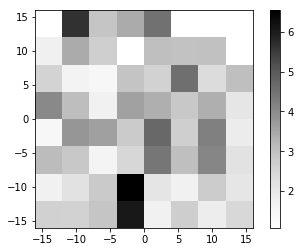

In [69]:
plt.imshow(excess, extent=[-16, 16, -16, 16], origin='lower', cmap='Greys')
plt.colorbar()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:64: RuntimeWarning: invalid value encountered in double_scalars


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:64: RuntimeWarning: invalid value encountered in sqrt


nan
-4.03672576257
-0.57494196406
-2.17735673867
-1.86714992993
-3.25290580232
-1.30387616825
-2.34782017858
-0.80274726887
-1.09639659404
-0.808189021264
-2.40822441086
-2.83751168121
-3.49161768666
-3.76376073845
-2.26161605967
-1.48099192511
0.610911298224
1.30490895527
1.30002579498
1.33771092803
2.99167801192
2.89757485534
3.82336597414
6.90267019849
7.43381527886
8.08303013503
7.6364978059
6.80356328742
5.75825781852
6.17373168362
4.80030812915
4.79878662896
3.42467702322
2.0062852672
0.772657276765
0.102361652887
-0.644320915213
0.118652365069
-0.0148835743238
-1.1138185258
-1.25388847277
-1.49248851396
-1.05495207489
-0.491364585983
-0.92457255529
-0.581105834469
-0.171124605291
-0.219240454303
-0.192336359414
1.74721161517
1.67955982591
1.15146027999
0.651273858189
1.03471490681
0.607331739683
1.26462172988
2.36133317631
3.81240109462
3.28603032242
2.97665155913
2.77457337429
2.51694747433
1.45187333986
1.11292406159
1.96341909587
1.65028323305
-0.294884078634
-0.556819692538


ValueError: Image size of 71678x884 pixels is too large. It must be less than 2^16 in each direction.

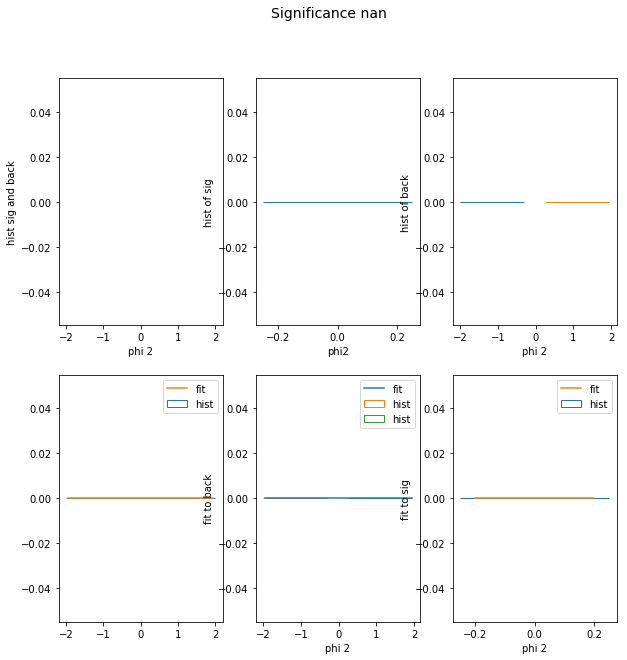

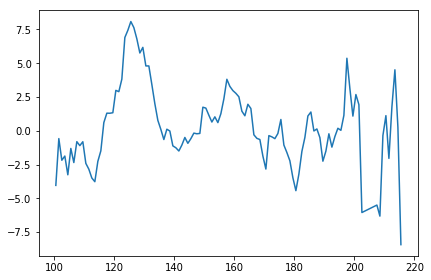

In [42]:
figAll, axesAll = plt.subplots()
fig, axes = plt.subplots(2, 3, figsize=(10,10))
fig2, axes2 = plt.subplots()
axes = axes.flatten()
excess = np.zeros(len(phi1_right_edges))
for i, (l, r) in enumerate(zip(phi1_left_edges, phi1_right_edges)): #np.unique(phi1bins):
#for i, l, r in zip([24], [phi1_left_edges[24]], [phi1_right_edges[24]]):
    for a in axes: a.cla()
    #search for over densities of stars along equator in Phi1 delta degree increments
    #stream is Phi2 = +-0.25 degrees from equator
    #background is Phi2 = +-2 degrees excluding stream 
    deltaPhi2 = phi2 - phi2_center
    
    posindices  = (phi1 >= l) & \
                  (phi1 <  r) & \
                  (np.abs(deltaPhi2) <= phi2_width) & pmindices
            
    notindices = (phi1 >= l) & \
                  (phi1 <  r) & \
                  (np.abs(deltaPhi2) <= background_widthmax) & ~pmindices
            
    backindices_low = (phi1 >= l) & \
                  (phi1 <  r) & \
                  (deltaPhi2 > -background_widthmax) & \
                  (deltaPhi2 < -background_widthmin) & pmindices
    backindices_high = (phi1 >= l) & \
                  (phi1 <  r) & \
                  (deltaPhi2 < background_widthmax) & \
                  (deltaPhi2 > background_widthmin) & pmindices
    allindices = (phi1 >= l) & \
                  (phi1 <  r) & \
                  (np.abs(deltaPhi2) <= background_widthmax) & pmindices
    axesAll.hist2d(phi1[allindices], phi2[allindices], bins=[20, 100])

    signal, bins_edges = np.histogram(phi2[posindices], bins=signalbins)
    background_low, bin_edges = np.histogram(phi2[backindices_low], bins=backgroundbins_low)
    background_high, bin_edges = np.histogram(phi2[backindices_high], bins=backgroundbins_high)
    #backgroundcenters = backgroundcenters[background > 0]
    #background = background[background > 0]
    axes[0].hist(phi2[allindices], bins=allbins, histtype='step', normed=True)
    axes[0].hist(phi2[notindices], bins=allbins, histtype='step', normed=True)
    axes[0].set_xlabel('phi 2')
    axes[0].set_ylabel('hist sig and back')
    axes[1].hist(phi2[posindices], bins=signalbins, histtype='step')
    axes[1].set_xlabel('phi2')
    axes[1].set_ylabel('hist of sig')
    axes[2].hist(phi2[backindices_low], bins=backgroundbins_low, histtype='step')
    axes[2].hist(phi2[backindices_high], bins=backgroundbins_high, histtype='step')
    axes[2].set_xlabel('phi 2')
    axes[2].set_ylabel('hist of back')
    bcfit = np.hstack((backgroundcenters_low, backgroundcenters_high))
    bsfit = np.hstack((background_low.astype('float64'), background_high.astype('float64')))

    p3 = np.poly1d(np.polyfit(bcfit, bsfit, 3))
    #cs = scint.CubicSpline(bcfit, bsfit)
    #cs = scint.UnivariateSpline(bcfit, bsfit, s=0.001)
    
    axes[3].hist(phi2[allindices], bins = allbins, label='hist', histtype='step')
    axes[3].plot(allcenters, p3(allcenters), label='fit')
    axes[4].plot(allcenters, p3(allcenters), label='fit')
    axes[3].legend()
    axes[4].hist(phi2[backindices_low], bins=backgroundbins_low, label='hist', histtype='step')
    axes[4].hist(phi2[backindices_high], bins=backgroundbins_high, label='hist', histtype='step')
    #axes[4].plot(allcenters, cs(allcenters), label='fit')
    axes[4].set_xlabel('phi 2')
    axes[4].set_ylabel('fit to back')
    axes[4].legend()
    axes[5].hist(phi2[posindices], bins=signalbins, label='hist', histtype='step')
    axes[5].plot(signalcenters, p3(signalcenters), label='fit')
    #print signalcenters
    #print cs(signalcenters)
    axes[5].set_xlabel('phi 2')
    axes[5].set_ylabel('fit to sig')
    axes[5].legend()
    #signal = signal.astype('float64') - p3(signalcenters)
    excess[i] = np.sum(signal - p3(signalcenters))/np.sqrt(np.sum(p3(signalcenters)))
    print excess[i]
    plt.tight_layout()
    fig.suptitle("Significance {0:0.2f}".format(excess[i]), fontsize=14)
    fig.savefig('fitBackground_{0:03d}'.format(i))

axes2.plot(phi1_centers[~np.isnan(excess)], excess[~np.isnan(excess)])